# Kaggle Days Warsaw 2018 - Part 1

This year on 18-19 of May I had an opportunity to take part in first ever offline kaggle competition - Kaggle Days Warsaw 2018. The competition goal was to predict the number of upvotes for given reddit answers, having information such as time or post content. Of all competing teams (around 40) my team was finally 12th. It's far from awesome, but given we compteted against much more experienced people (and Kaggle Masters) I consider this a decent result.

My aim is to improve our result and check which place could we reach with some improvements in our code. I'll start with some exploratory data analysis and feature engineering. For next steps, check my other notebook (Part 2).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import log
from matplotlib import pyplot as plt
import re

In [2]:
#load data...
df = pd.read_csv("train.csv", sep="\t", index_col='id')

In [3]:
#df.info()

In [4]:
#df.head()

In [5]:
#df.describe()

In [6]:
#some type conversion
coltypes = {"question_id":"str", 
            "subreddit":"str", 
            "question_utc":"datetime64[s]",
            "question_text": "str", 
            "question_score":"int32", #notice how large these values are
            "answer_utc":"datetime64[s]",
            "answer_text":"str", 
            "answer_score":"int32"} #check

for col, coltype in coltypes.items():
    if col in df.columns:
        df[col] = df[col].astype(coltype)

## Looking at data

In [7]:
df.head() #check if e.g. dates are parsed correctly

,question_id,subreddit,question_utc,question_text,question_score,answer_utc,answer_text,answer_score
id,,,,,,,,
330435,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 00:03:36,"I didn't really care for it, I thought the pac...",70
1944975,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 01:11:34,"I thought it was hilarious, and I didn't reali...",24
2218735,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 01:12:43,"&gt; Pacific Rim The porno, or the studio rel...",11
2133251,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 01:22:29,I enjoyed it more than most movies of that gen...,42
2133252,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 12:56:52,"Its terrible, its clearly made to be a self aw...",1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 852885 entries, 330435 to 2646893
Data columns (total 8 columns):
question_id       852885 non-null object
subreddit         852885 non-null object
question_utc      852885 non-null datetime64[ns]
question_text     852885 non-null object
question_score    852885 non-null int32
answer_utc        852885 non-null datetime64[ns]
answer_text       852885 non-null object
answer_score      852885 non-null int32
dtypes: datetime64[ns](2), int32(2), object(4)
memory usage: 52.1+ MB


In [9]:
#no nulls, but check for sure
df.isnull().any().any()

False

In [10]:
df.describe() #not much to do here

,question_score,answer_score
count,852885.000000,852885.000000
mean,770.891169,17.808687
std,3094.752794,182.754614
min,1.000000,1.000000
25%,2.000000,1.000000
50%,11.000000,2.000000
75%,112.000000,5.000000
max,48834.000000,27927.000000


In [11]:
df.apply(lambda x: x.nunique())

question_id       500000
subreddit             41
question_utc      324012
question_text     494147
question_score      3496
answer_utc        443244
answer_text       830658
answer_score        2440
dtype: int64

In all 852885 reddit posts we have 50k questions, groupped in 41 subreddits

#### So basically we have three groups of features:
1. Text (question and answer text, subreddit)
2. Datetime (question and answer utc's)
3. Numeric (question and answer scores, the latter we're trying to predict and it's absent in train set)

#### Let's approach them group at a time

### Text data

#### Some hypotheses and new feature ideas:
Answer/Question length - should affect the number of upvotes (the longer the text, the less peaople read it). <br>
Number of capital letters - 'allcaps' looks bad, also can mean we're dealing with trolls, haters etc. <br>
Additional content - like links or images, can make answer more popular, at leat when there not too many of it <br>
Subreddit - can affect answer's score in many ways (popularity, funny/serious, dominated by trolls etc.)

In [12]:
#uppercases
df['uppercase_count_q'] = df['question_text'].str.findall(r'[A-Z]').str.len()
df['uppercase_count_a'] = df['answer_text'].str.findall(r'[A-Z]').str.len()

#count of answers
df["answer_count"] = df.groupby(['question_id'])['answer_text'].transform('count')
df["answer_lowcount"] = df["answer_count"] < 200

#extra content - links and images
url_regex = 'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+'
img_regex = 'https?:[^)''"]+\.(?:jpg|jpeg|gif|png)'

df['answer_links'] = df['answer_text'].apply(lambda x: len(re.findall(url_regex, x)))
df['answer_imgs'] = df['answer_text'].apply(lambda x: len(re.findall(img_regex, x)))
df['answer_imgs'] = df.answer_imgs.apply(lambda x: 6 if x > 6 else x)
df['answer_links'] = df.answer_links.apply(lambda x: 10 if x > 10 else x)

#length
df['answer_length'] = df['answer_text'].apply(lambda x: len(x))
df['answer_is_long'] = df['answer_length'] < 1500 #seems reasonable, see below
df['answer_sents'] = df['answer_text'].apply(lambda x: len(re.findall(r'.*[.!?]', x))) #not 100% accurate but should do the job

In [13]:
#df.corr(method = "kendall") #correlations are pretty weak

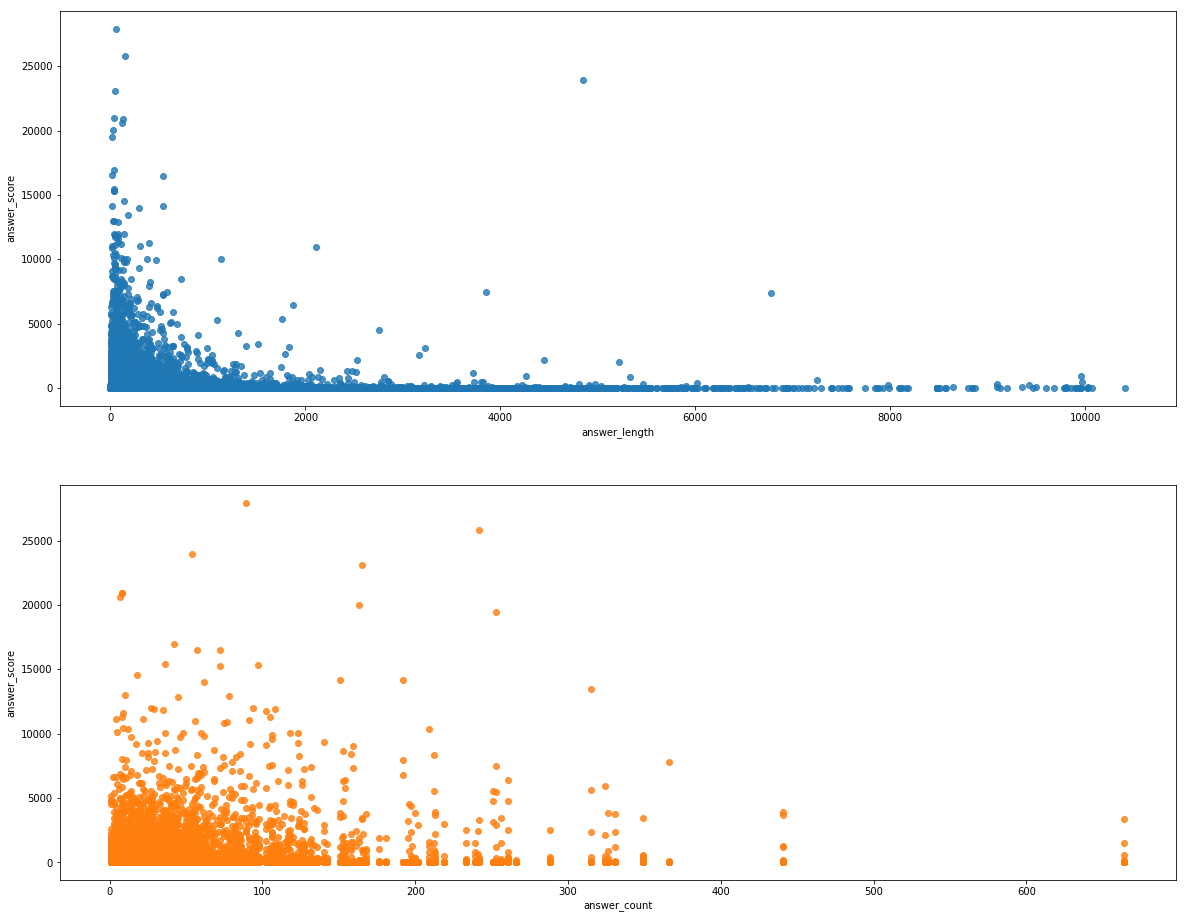

In [14]:
_, axes = plt.subplots(2, 1, figsize=(20, 16));
sns.regplot(x=df["answer_length"], y=df["answer_score"], fit_reg=False, ax=axes[0]);
sns.regplot(x=df["answer_count"], y=df["answer_score"], fit_reg=False, ax=axes[1]);
#sns.boxplot(x=df["answer_imgs"], y=df["answer_score"], ax=axes[1]);
#sns.boxplot(x=df["answer_links"], y=df["answer_score"], ax=axes[2]);

### Datetime

In [15]:
df['question_utc'].min(), df['question_utc'].max()

(Timestamp('2017-12-01 00:00:00'), Timestamp('2017-12-07 19:20:53'))

In [16]:
df['answer_utc'].min(), df['answer_utc'].max() #notice there are holidays in December

(Timestamp('2017-12-01 00:00:37'), Timestamp('2017-12-31 23:36:21'))

Feature ideas:
1. Answer delay - the more time from posting question, the less likely that answet will be upvoted
2. Day of week - possibly more activity at weekend, hence more upvotes
3. Hour - should not expect too many upvotes in the middle of the night
4. Tag holidays in december - maybe people will spend Christmas with their faimiles, not on reddit?
5. Maybe some 'bigger' patterns in time

In [17]:
df["answer_delay"] = (df.answer_utc - df.question_utc).dt.total_seconds().apply(lambda x: log(x+1))
df["answer_day_of_week"] = df["answer_utc"].dt.dayofweek
df["answer_hour"] = df["answer_utc"].dt.hour
df["answer_time_of_day"] = df["answer_utc"].dt.hour*24  + df["answer_utc"].dt.minute
df["answer_holidays"] = df["answer_utc"] >= '2017-12-24'
df["time_trend"] = (df["answer_utc"] - df["answer_utc"].min()).dt.total_seconds()/3600
df["trend_low"] = df["time_trend"] < 175 #see 'drop' on chart below

In [18]:
df["answer_holidays"].sum() #not too many...

375

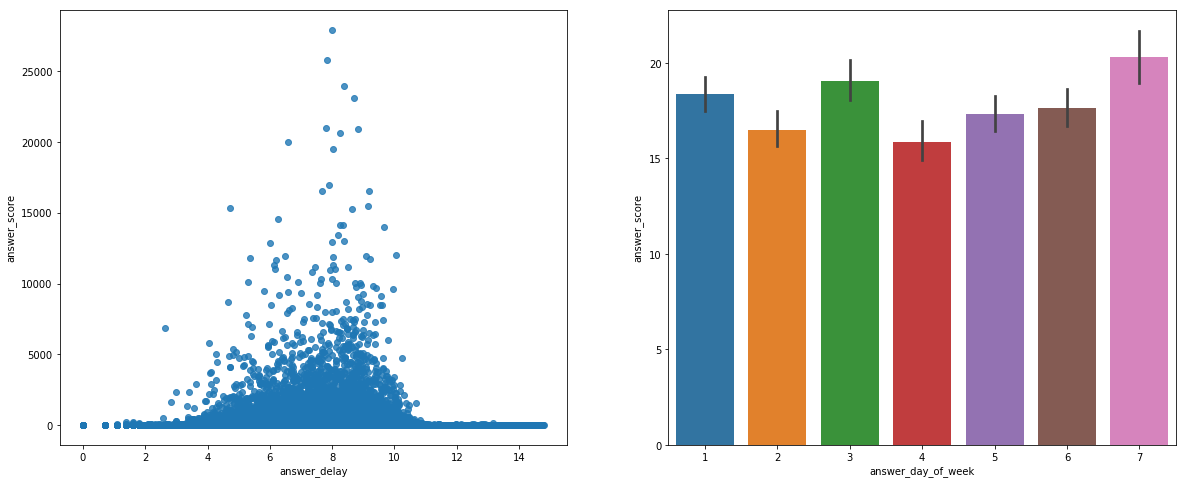

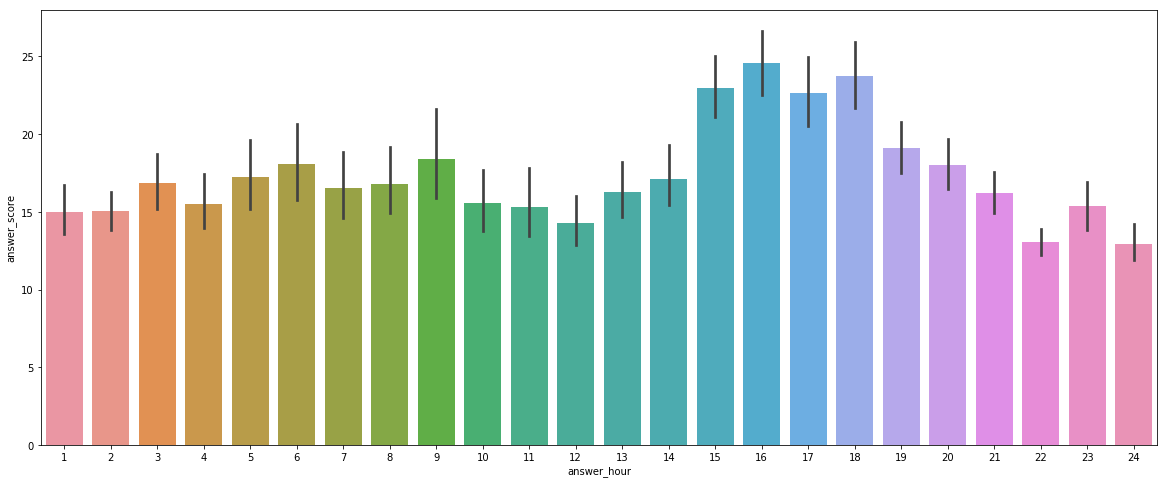

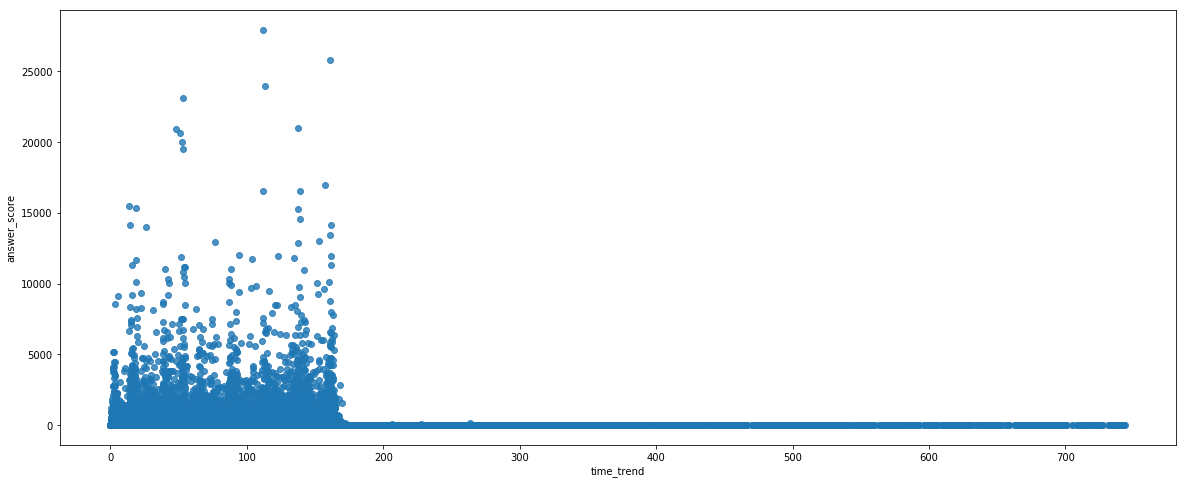

In [19]:
_, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.regplot(x=df["answer_delay"], y=df["answer_score"], ax = axes[0], fit_reg=False);
sns.barplot(x=df["answer_day_of_week"]+1, y=df["answer_score"]);

_, axes = plt.subplots(1, 1, figsize=(20, 8))
sns.barplot(x=df["answer_hour"]+1, y=df["answer_score"])


_, ax = plt.subplots(1, 1, figsize=(20, 8))
# sns.jointplot(x=df["answer_tod"], y=df["answer_score"], kind="hex") 
sns.regplot(x=df["time_trend"], y=df["answer_score"], fit_reg=False, ax=ax);

### Numeric

Question score seems to be out best predictor (see correlation wih answer score), although we don't have many options here

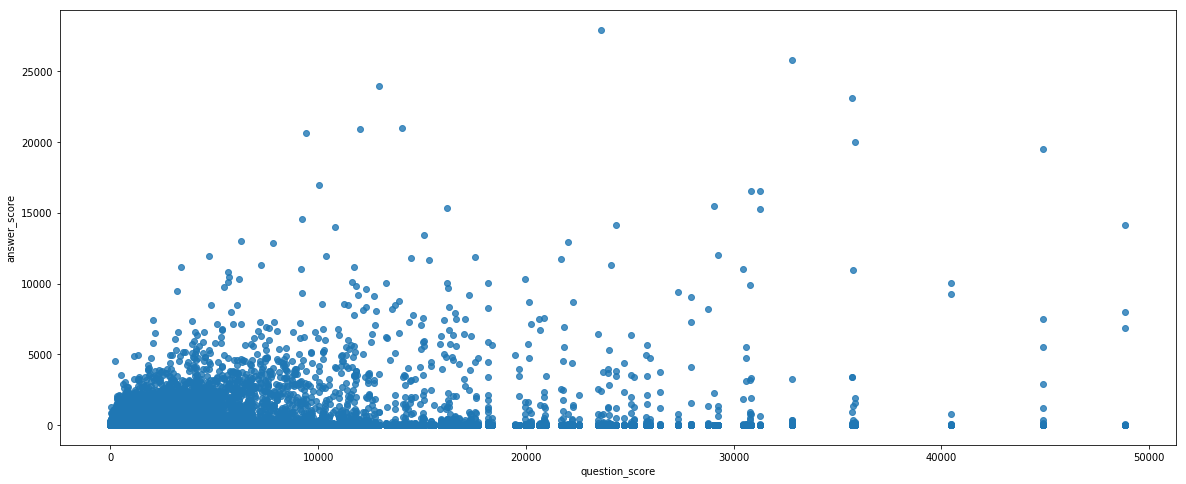

In [20]:
_, axes = plt.subplots(1, 1, figsize=(20, 8));
sns.regplot(x=df["question_score"], y=df["answer_score"], fit_reg=False);

In [21]:
df.head()

,question_id,subreddit,question_utc,question_text,question_score,answer_utc,answer_text,answer_score,uppercase_count_q,uppercase_count_a,...,answer_length,answer_is_long,answer_sents,answer_delay,answer_day_of_week,answer_hour,answer_time_of_day,answer_holidays,time_trend,trend_low
id,,,,,,,,,,,,,,,,,,,,,
330435,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 00:03:36,"I didn't really care for it, I thought the pac...",70,7,2,...,59,True,0,5.379897,4,0,3,False,0.049722,True
1944975,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 01:11:34,"I thought it was hilarious, and I didn't reali...",24,7,2,...,75,True,1,8.365207,4,1,35,False,1.182500,True
2218735,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 01:12:43,"&gt; Pacific Rim The porno, or the studio rel...",11,7,3,...,52,True,1,8.381144,4,1,36,False,1.201667,True
2133251,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 01:22:29,I enjoyed it more than most movies of that gen...,42,7,2,...,78,True,1,8.507143,4,1,46,False,1.364444,True
2133252,f48a5420fa6a66ecec95365dd67bdc99,AskReddit,2017-12-01,All my buddies love Pacific Rim and always tal...,179,2017-12-01 12:56:52,"Its terrible, its clearly made to be a self aw...",1,7,14,...,160,True,0,10.749635,4,12,344,False,12.937500,True


In [22]:
df['q_score_subreddit_median'] = df.groupby(['subreddit'])['question_score'].transform('median')
df['q_score_subreddit_mean'] = df.groupby(['subreddit'])['question_score'].transform('mean')

In [23]:
df.corr(method='kendall') #once again

,question_score,answer_score,uppercase_count_q,uppercase_count_a,answer_count,answer_lowcount,answer_links,answer_imgs,answer_length,answer_is_long,answer_sents,answer_delay,answer_day_of_week,answer_hour,answer_time_of_day,answer_holidays,time_trend,trend_low,q_score_subreddit_median,q_score_subreddit_mean
question_score,1.000000,0.261269,0.096323,-0.012811,0.654351,-0.132681,-0.018635,0.003030,-0.025043,0.029940,0.006764,0.289632,0.000359,0.016058,0.015772,0.000088,0.030806,-0.001671,0.165954,0.144896
answer_score,0.261269,1.000000,-0.007039,0.035642,0.117869,0.065349,0.011618,0.011391,0.036366,0.004961,0.022295,-0.104752,-0.001849,0.006003,0.005896,-0.015167,-0.028083,0.058735,0.018666,-0.013676
uppercase_count_q,0.096323,-0.007039,1.000000,0.188921,0.133446,-0.064170,0.010284,-0.003548,0.183142,-0.052333,0.122712,0.094000,-0.005788,0.016290,0.015996,0.003838,0.020940,-0.013440,-0.023836,-0.018627
uppercase_count_a,-0.012811,0.035642,0.188921,1.000000,0.010105,0.000653,0.120138,0.031753,0.564498,-0.118564,0.299285,0.038339,-0.013069,0.016134,0.015807,-0.001500,0.010171,-0.003515,-0.049731,-0.045907
answer_count,0.654351,0.117869,0.133446,0.010105,1.000000,-0.151754,-0.008968,0.001004,0.008291,0.021107,0.016580,0.277250,0.000717,0.019277,0.018950,0.000971,0.035441,-0.006994,0.148505,0.140475
answer_lowcount,-0.132681,0.065349,-0.064170,0.000653,-0.151754,1.000000,0.008080,0.002052,0.003892,-0.005443,-0.001461,-0.065487,-0.007679,-0.032781,-0.032409,-0.000396,-0.065202,0.015193,-0.065780,-0.082991
answer_links,-0.018635,0.011618,0.010284,0.120138,-0.008968,0.008080,1.000000,0.325372,0.104739,-0.082169,0.082122,-0.002002,0.000451,0.002206,0.002139,-0.000342,-0.004089,-0.000676,-0.032670,-0.034857
answer_imgs,0.003030,0.011391,-0.003548,0.031753,0.001004,0.002052,0.325372,1.000000,0.020657,-0.019409,0.026826,0.000502,-0.001232,0.000786,0.000785,-0.001303,-0.002229,0.002318,-0.009253,-0.014424
answer_length,-0.025043,0.036366,0.183142,0.564498,0.008291,0.003892,0.104739,0.020657,1.000000,-0.113341,0.339893,0.041077,-0.019396,0.020276,0.019923,-0.001381,0.017338,-0.004136,-0.065694,-0.053703
answer_is_long,0.029940,0.004961,-0.052333,-0.118564,0.021107,-0.005443,-0.082169,-0.019409,-0.113341,1.000000,-0.034411,-0.013548,0.002251,0.000087,0.000184,0.000291,-0.003839,0.005063,0.018662,0.013155


### Conclusions & next steps
1. Many new feautures are 'longshots'
2. Feature engineering is not easy and takes a lot of time - using genetic algorithms to find new ones seems to be good idea
3. Try certain hours (e.g. 15-19)
4. I'll probably include some of them in my model - see you in next notebook!